In [1]:
import os, sys
import pandas as pd
import numpy as np

#Plot settings
from coffea import hist
from coffea.processor import defaultdict_accumulator

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import mplhep as hep
plt.style.use(hep.style.ROOT)

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)

#Just to efficiently save plots
plot_dir = "/u/gu/dhoang/ldmx_plot/"
from datetime import datetime
now = datetime.now()
dt_string = now.strftime("%d-%m-%Y")

save_path = plot_dir + dt_string
print("Saving plot to: ", save_path)


def trigger_weight_1D(pt, mode = 'loose'):
    
    if mode == 'loose':
        trigger_weight = np.asarray([0.010826347305389221,
                                     0.07083333333333333,
                                     0.3373493975903614,
                                     0.7386363636363636,
                                     0.9541284403669725,
                                     0.9895833333333334,
                                     0.9859154929577465,
                                     0.9824561403508771,
                                     0.92,
                                     0.926829268292683])
    else:
        trigger_weight = np.asarray([0.0011976047904191617,
                                     0.03958333333333333,
                                     0.24899598393574296,
                                     0.6534090909090909,
                                     0.8715596330275229,
                                     0.8854166666666666,
                                     0.8591549295774648,
                                     0.9122807017543859,
                                     0.72,
                                     0.8048780487804879])
        
    
    edges = np.asarray([0.0, 100.0, 200.0, 300.0, 400.0, 500.0, 600.0, 700.0, 800.0, 900.0, 1000.0])/1000.
    
    if pt >= edges[-1]:
        weight = trigger_weight[-1]
    elif pt <= edges[0]:
        weight = 0
    else:
        weight = trigger_weight[(pt >= edges[:-1]) & (pt <= edges[1:])]
        
    return float(weight) 

Saving plot to:  /u/gu/dhoang/ldmx_plot/01-04-2021


## 1. Explore

In [5]:
hists = {}
hists["lepton_pt"] = hist.Hist("Events", hist.Cat("sample", "Sample name"), 
                               hist.Bin("pt", r"Final State Lepton $p_{T}$ [GeV/c]", 20, 0, 1))

In [6]:
gst_df = pd.read_hdf("../data/base_generation_with_weights_02Mar21_0.hdf", key="gst_df")

query='index' #all
df=gst_df.query(query)

In [7]:
c = df['ptl'].apply(trigger_weight_1D, mode = 'tight')

In [8]:
(df['ptl']*c).to_numpy()

array([0.00673245, 0.00692796, 0.25622072, ..., 0.00745884, 0.0073894 ,
       0.61255216])

In [14]:
c

0        0.039583
1        0.039583
2        0.653409
3        0.248996
4        0.248996
           ...   
99995    0.039583
99996    0.248996
99997    0.039583
99998    0.039583
99999    0.720000
Name: ptl, Length: 100000, dtype: float64

## 2. Processor

In [2]:
hists = {}

hists["lepton_pt"] = hist.Hist("Events", hist.Cat("sample", "Sample name"), 
                               hist.Bin("pt", r"Final State Lepton $p_{T}$ [GeV/c]", 20, 0, 1))
hists["lepton_e"] = hist.Hist("Events", hist.Cat("sample", "Sample name"), 
                               hist.Bin("e", r"Final State Lepton E [GeV]", 20, 0, 4))

hists["p1_pt"] = hist.Hist("Events", hist.Cat("sample", "Sample name"), 
                               hist.Bin("pt", r"Final State Proton $p_{T}$ [GeV/c]", 20, 0, 1.6))
hists["p1_e"] = hist.Hist("Events", hist.Cat("sample", "Sample name"), 
                               hist.Bin("e", r"Final State Proton E [GeV]", 20, 0, 4))
hists["p1_ke"] = hist.Hist("Events", hist.Cat("sample", "Sample name"), 
                               hist.Bin("ke", r"Final State Proton KE [GeV]", 20, 0, 4))

hists["n1_pt"] = hist.Hist("Events", hist.Cat("sample", "Sample name"), 
                               hist.Bin("pt", r"Final State Neutron $p_{T}$ [GeV/c]", 20, 0, 1.6))
hists["n1_e"] = hist.Hist("Events", hist.Cat("sample", "Sample name"), 
                               hist.Bin("e", r"Final State Neutron E [GeV]", 20, 0, 4))
hists["n1_ke"] = hist.Hist("Events", hist.Cat("sample", "Sample name"), 
                               hist.Bin("ke", r"Final State Neutron KE [GeV]", 20, 0, 4))

In [3]:
def processor(file_name, config_mode = 'loose'):
    
    gst_df = pd.read_hdf(file_name, key="gst_df")

    query='index' #all
    df=gst_df.query(query)
    
    #Varibale parameters
    wght="MFP_pi"
    sigma=1
    units="GeV/c"
    
    
    #--------------------LEADING LEPTONS
    #1D trigger simulation
    trigger_weights = df['ptl'].apply(trigger_weight_1D, mode = config_mode)
    
    CV_weight = (df["wght"]*trigger_weights).to_numpy()
    plus_sigma_weight = (df["wght_%s_p%d"%(wght,sigma)]*trigger_weights).to_numpy()
    minus_sigma_weight =  (df["wght_%s_n%d"%(wght,sigma)]*trigger_weights).to_numpy()
    
    #Lepton's pT
    lepton_pt = df['ptl'].to_numpy()
    
    hists["lepton_pt"].fill(sample = 'CV', pt = lepton_pt, weight = CV_weight)
    
    hists["lepton_pt"].fill(sample = "%s +%d$\sigma$"%(wght,sigma), pt = lepton_pt,
                            weight= plus_sigma_weight)
    
    hists["lepton_pt"].fill(sample = "%s -%d$\sigma$"%(wght,sigma), pt = lepton_pt,
                            weight= minus_sigma_weight)
    
    #Energy of lepton
    lepton_e = df['El'].to_numpy()
    hists["lepton_e"].fill(sample = 'CV', e = lepton_e, weight = CV_weight)
    
    hists["lepton_e"].fill(sample = "%s +%d$\sigma$"%(wght,sigma), e = lepton_e,
                            weight= plus_sigma_weight)
    
    hists["lepton_e"].fill(sample = "%s -%d$\sigma$"%(wght,sigma), e = lepton_e,
                            weight= minus_sigma_weight)
    
    #--------------------LEADING PROTONS
    proton_pt = np.hypot(df['px_p1'], df['py_p1']).to_numpy()
    
    #Proton pt
    hists["p1_pt"].fill(sample = 'CV', pt = proton_pt, weight = CV_weight)
    
    hists["p1_pt"].fill(sample = "%s +%d$\sigma$"%(wght,sigma), pt = proton_pt,
                       weight= plus_sigma_weight)
    
    hists["p1_pt"].fill(sample = "%s -%d$\sigma$"%(wght,sigma), pt = proton_pt,
                        weight= minus_sigma_weight)
    #Proton Energy
    proton_e = df['E_p1'].to_numpy()
    hists["p1_e"].fill(sample = 'CV', e = proton_e, weight = CV_weight)
    
    hists["p1_e"].fill(sample = "%s +%d$\sigma$"%(wght,sigma), e = proton_e,
                       weight= plus_sigma_weight)
    
    hists["p1_e"].fill(sample = "%s -%d$\sigma$"%(wght,sigma), e = proton_e,
                        weight= minus_sigma_weight)
    
    #Proton Kinetic Energy
    proton_ke = df['ke_p1'].to_numpy()
    hists["p1_ke"].fill(sample = 'CV', ke = proton_ke, weight = CV_weight)
    hists["p1_ke"].fill(sample = "%s +%d$\sigma$"%(wght,sigma), ke = proton_ke,
                       weight= plus_sigma_weight)
    hists["p1_ke"].fill(sample = "%s -%d$\sigma$"%(wght,sigma), ke = proton_ke,
                        weight= minus_sigma_weight)
    
    #--------------------LEADING NEUTRONs
    neutron_pt = np.hypot(df['px_n1'], df['py_n1']).to_numpy()
    
    #Neutron pt
    hists["n1_pt"].fill(sample = 'CV', pt = neutron_pt, weight = CV_weight)
    
    hists["n1_pt"].fill(sample = "%s +%d$\sigma$"%(wght,sigma), pt = neutron_pt,
                       weight= plus_sigma_weight)
    
    hists["n1_pt"].fill(sample = "%s -%d$\sigma$"%(wght,sigma), pt = neutron_pt,
                        weight= minus_sigma_weight)
    #Neutron Energy
    neutron_e = df['E_n1'].to_numpy()
    hists["n1_e"].fill(sample = 'CV', e = neutron_e, weight = CV_weight)
    
    hists["n1_e"].fill(sample = "%s +%d$\sigma$"%(wght,sigma), e = neutron_e,
                       weight= plus_sigma_weight)
    
    hists["n1_e"].fill(sample = "%s -%d$\sigma$"%(wght,sigma), e = neutron_e,
                        weight= minus_sigma_weight)
    
    #Proton Kinetic Energy
    neutron_ke = df['ke_n1'].to_numpy()
    hists["n1_ke"].fill(sample = 'CV', ke = neutron_ke, weight = CV_weight)
    hists["n1_ke"].fill(sample = "%s +%d$\sigma$"%(wght,sigma), ke = neutron_ke,
                       weight= plus_sigma_weight)
    hists["n1_ke"].fill(sample = "%s -%d$\sigma$"%(wght,sigma), ke = neutron_ke,
                        weight= minus_sigma_weight)
    
    %reset -f in

## 1. Loose configuration

In [4]:
chunk = 0

for filename in os.listdir("../data/"):
    if filename.startswith("base_generation_with_weights_02Mar21_"):
        f_path = os.path.join("../data/", filename)
        processor(f_path)
        
        chunk += 1
#        if chunk == 1:
#            break

Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history


/u/gu/dhoang/ldmx_plot/31-03-2021final_state_n1_pt_loose_trigger.pdf


'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


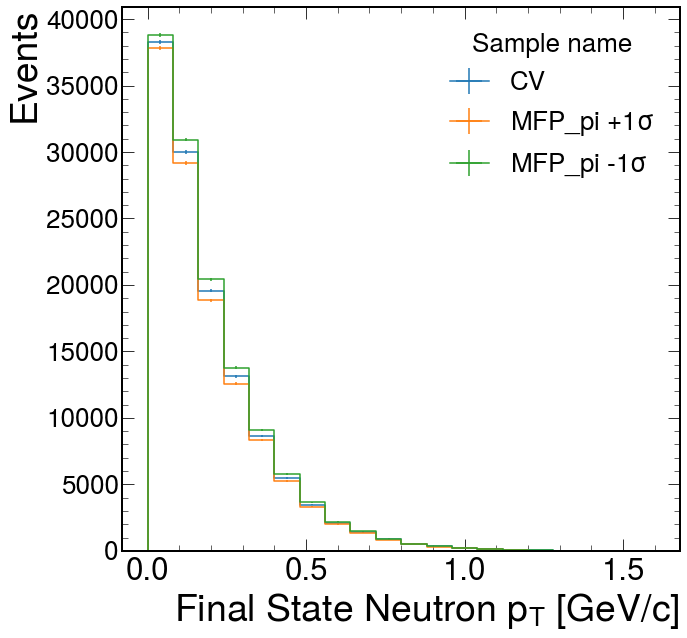

In [17]:
hist.plot1d(hists["n1_pt"], overflow = 'all')
print(save_path + "final_state_n1_pt_loose_trigger.pdf")
plt.savefig(save_path + "final_state_n1_pt_loose_trigger.pdf", bbox_inches = 'tight')

/u/gu/dhoang/ldmx_plot/31-03-2021final_state_n1_ke_loose_trigger.pdf


'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


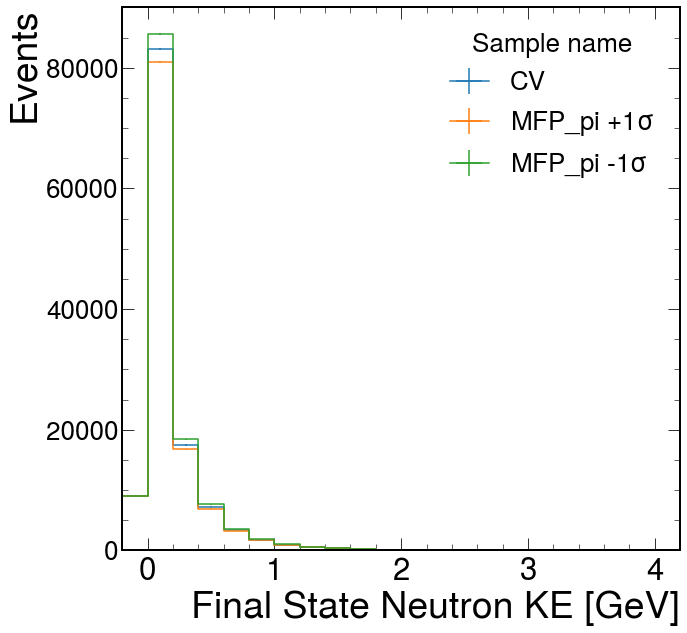

In [18]:
hist.plot1d(hists["n1_ke"], overflow = 'all')
print(save_path + "final_state_n1_ke_loose_trigger.pdf")
plt.savefig(save_path + "final_state_n1_ke_loose_trigger.pdf", bbox_inches = 'tight')

/u/gu/dhoang/ldmx_plot/31-03-2021final_state_n1_e_loose_trigger.pdf


'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


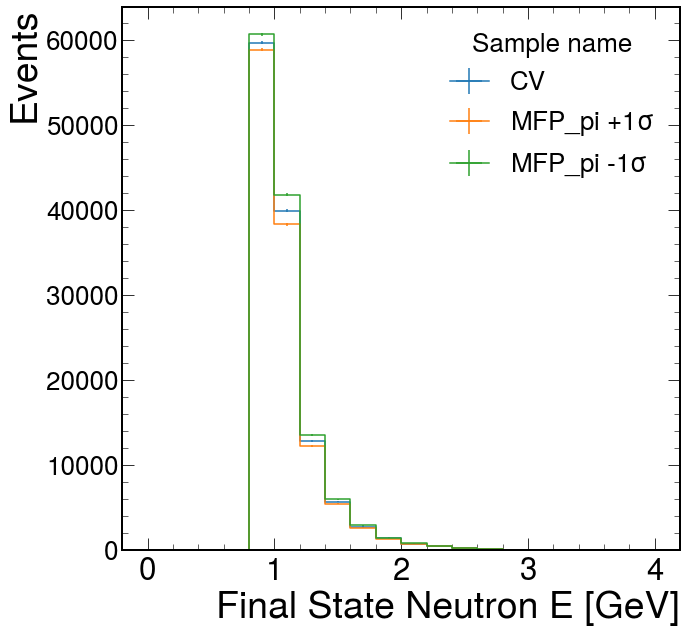

In [19]:
hist.plot1d(hists["n1_e"], overflow = 'all')
print(save_path + "final_state_n1_e_loose_trigger.pdf")
plt.savefig(save_path + "final_state_n1_e_loose_trigger.pdf", bbox_inches = 'tight')

/u/gu/dhoang/ldmx_plot/31-03-2021final_state_p1_pt_loose_trigger.pdf


'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


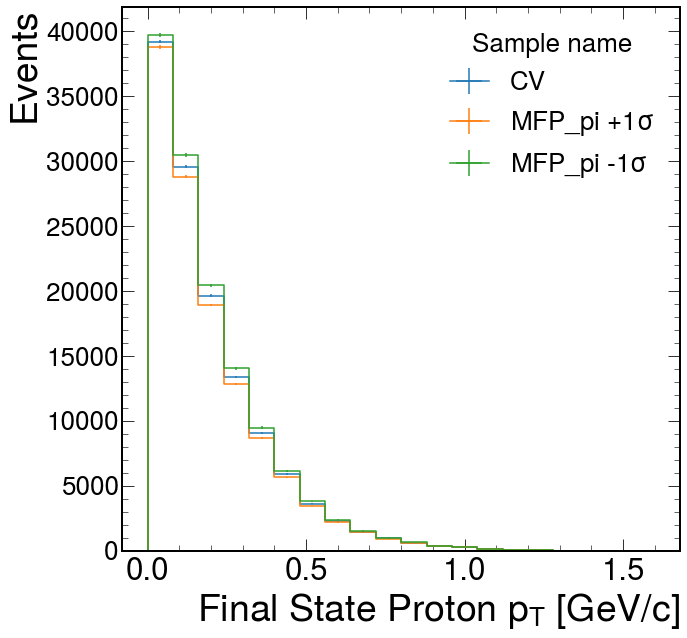

In [24]:
hist.plot1d(hists["p1_pt"], overflow = 'all')
print(save_path + "final_state_p1_pt_loose_trigger.pdf")
plt.savefig(save_path + "final_state_p1_pt_loose_trigger.pdf", bbox_inches = 'tight')

/u/gu/dhoang/ldmx_plot/31-03-2021final_state_p1_e_loose_trigger.pdf


'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


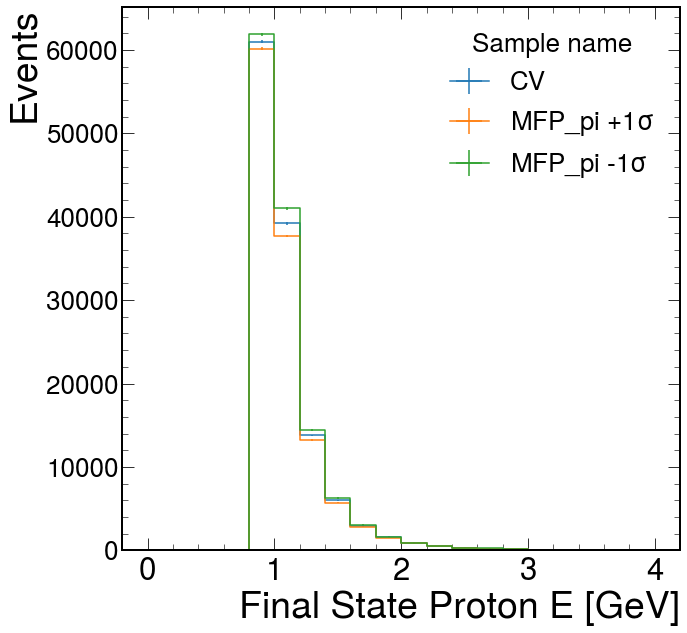

In [25]:
hist.plot1d(hists["p1_e"], overflow = 'all')
print(save_path + "final_state_p1_e_loose_trigger.pdf")
plt.savefig(save_path + "final_state_p1_e_loose_trigger.pdf", bbox_inches = 'tight')

/u/gu/dhoang/ldmx_plot/31-03-2021final_state_p1_ke_loose_trigger.pdf


'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


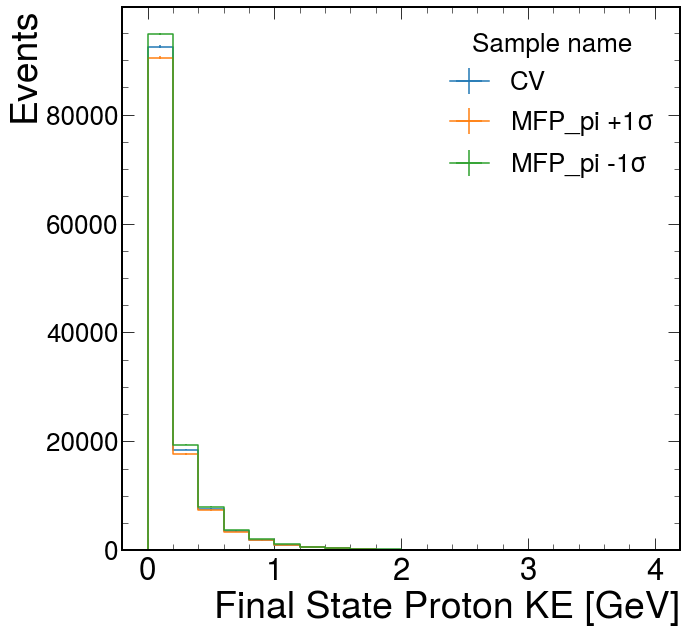

In [26]:
hist.plot1d(hists["p1_ke"], overflow = 'all')
print(save_path + "final_state_p1_ke_loose_trigger.pdf")
plt.savefig(save_path + "final_state_p1_ke__loose_trigger.pdf", bbox_inches = 'tight')

/u/gu/dhoang/ldmx_plot/31-03-2021final_state_l_pt_loose_trigger.pdf


'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


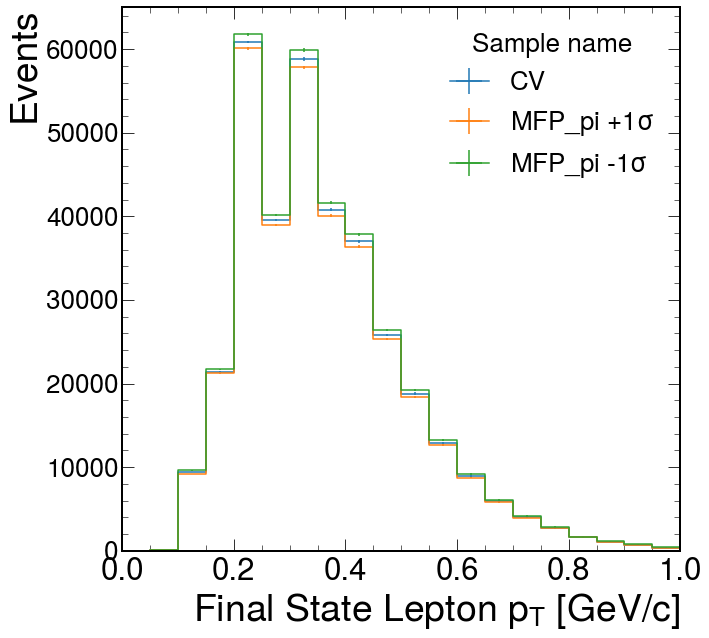

In [22]:
hist.plot1d(hists["lepton_pt"])
print(save_path + "final_state_l_pt_loose_trigger.pdf")
plt.savefig(save_path + "final_state_l_pt_loose_trigger.pdf", bbox_inches = 'tight')

/u/gu/dhoang/ldmx_plot/31-03-2021final_state_e_pt_loose_trigger.pdf


'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


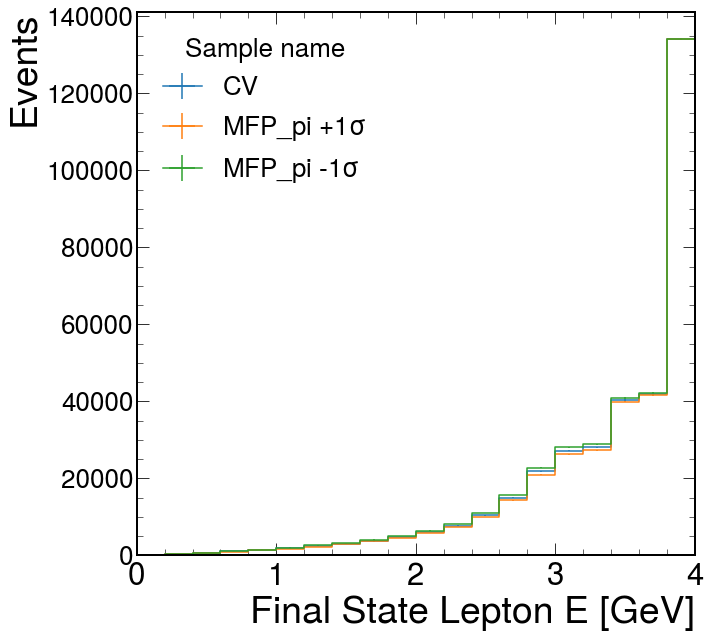

In [23]:
hist.plot1d(hists["lepton_e"])
print(save_path + "final_state_e_pt_loose_trigger.pdf")
plt.savefig(save_path + "final_state_e_pt_loose_trigger.pdf", bbox_inches = 'tight')

## 2. Tight configuration

In [4]:
chunk = 0

for filename in os.listdir("../data/"):
    if filename.startswith("base_generation_with_weights_02Mar21_"):
        f_path = os.path.join("../data/", filename)
        processor(f_path, config_mode = 'tight')
        
        chunk += 1
#        if chunk == 1:
#            break

Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history


/u/gu/dhoang/ldmx_plot/01-04-2021final_state_n1_pt_loose_trigger.pdf


'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


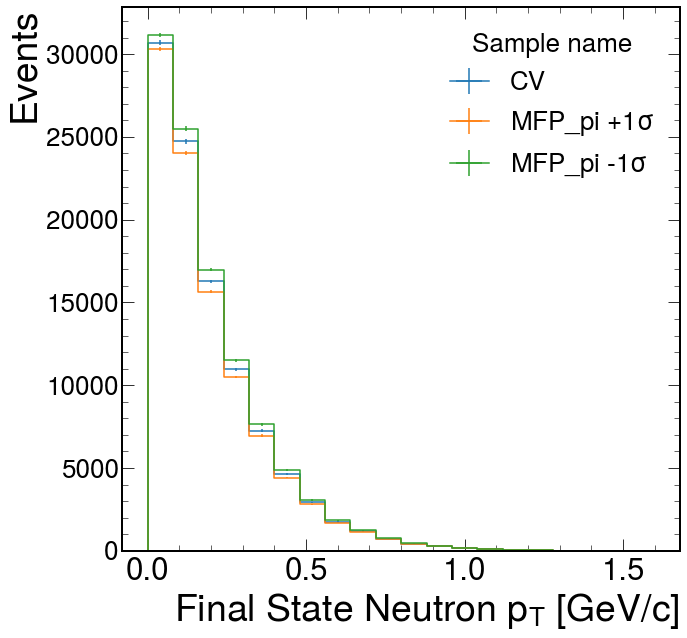

In [5]:
hist.plot1d(hists["n1_pt"], overflow = 'all')
print(save_path + "final_state_n1_pt_loose_trigger.pdf")
plt.savefig(save_path + "final_state_n1_pt_tight_trigger.pdf", bbox_inches = 'tight')

/u/gu/dhoang/ldmx_plot/01-04-2021final_state_n1_e_loose_trigger.pdf


'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


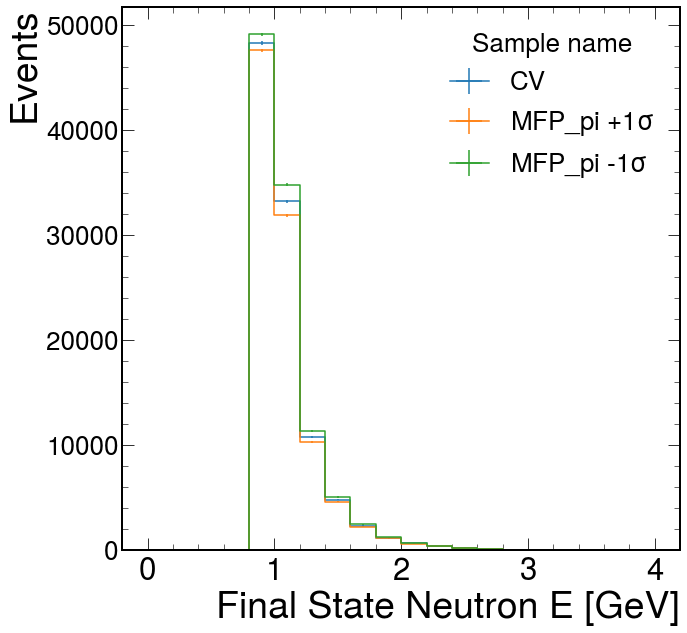

In [6]:
hist.plot1d(hists["n1_e"], overflow = 'all')
print(save_path + "final_state_n1_e_loose_trigger.pdf")
plt.savefig(save_path + "final_state_n1_e_tight_trigger.pdf", bbox_inches = 'tight')

/u/gu/dhoang/ldmx_plot/01-04-2021final_state_n1_ke_loose_trigger.pdf


'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


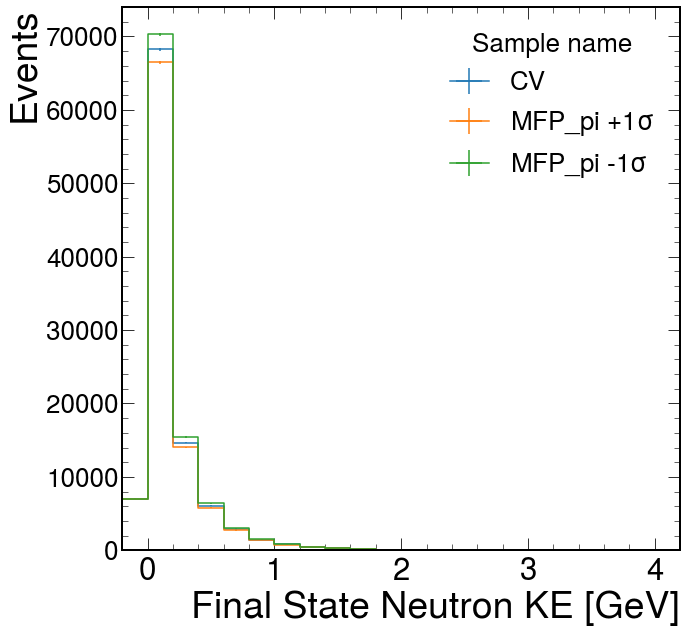

In [7]:
hist.plot1d(hists["n1_ke"], overflow = 'all')
print(save_path + "final_state_n1_ke_loose_trigger.pdf")
plt.savefig(save_path + "final_state_n1_ke_tight_trigger.pdf", bbox_inches = 'tight')

/u/gu/dhoang/ldmx_plot/01-04-2021final_state_p1_pt_loose_trigger.pdf


'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


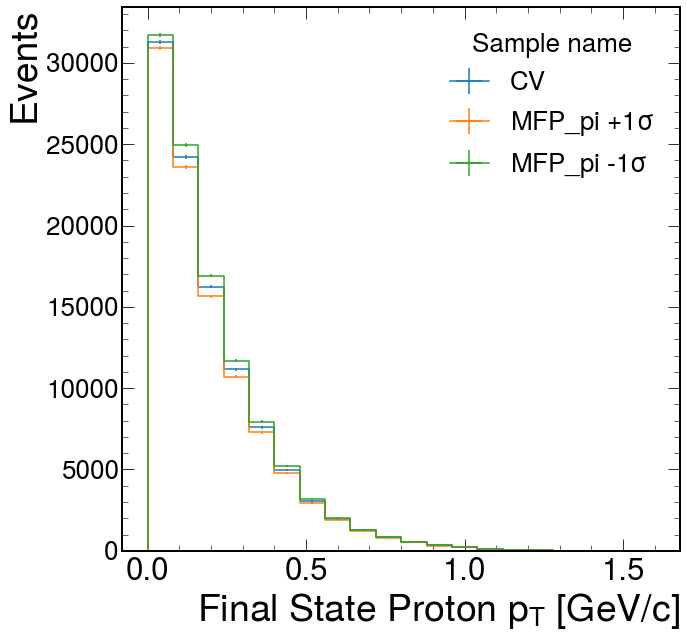

In [8]:
hist.plot1d(hists["p1_pt"], overflow = 'all')
print(save_path + "final_state_p1_pt_loose_trigger.pdf")
plt.savefig(save_path + "final_state_p1_pt_tight_trigger.pdf", bbox_inches = 'tight')

/u/gu/dhoang/ldmx_plot/01-04-2021final_state_p1_e_loose_trigger.pdf


'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


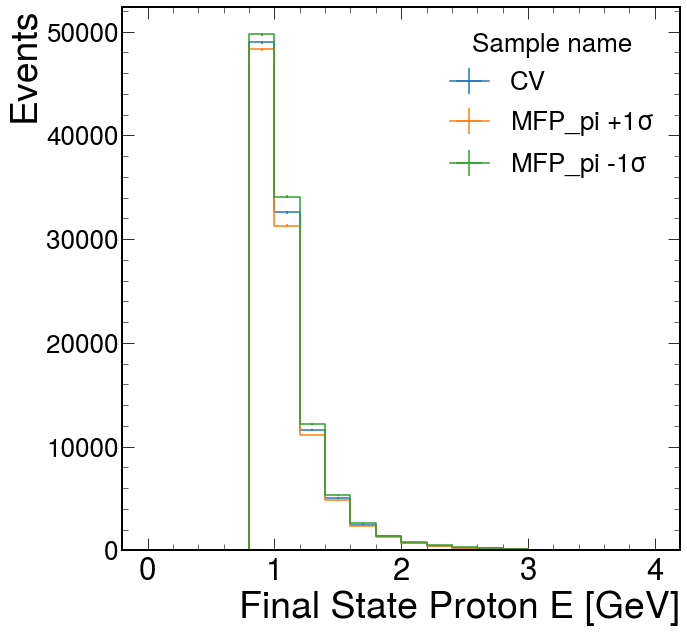

In [9]:
hist.plot1d(hists["p1_e"], overflow = 'all')
print(save_path + "final_state_p1_e_loose_trigger.pdf")
plt.savefig(save_path + "final_state_p1_e_tight_trigger.pdf", bbox_inches = 'tight')

/u/gu/dhoang/ldmx_plot/01-04-2021final_state_p1_ke_loose_trigger.pdf


'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


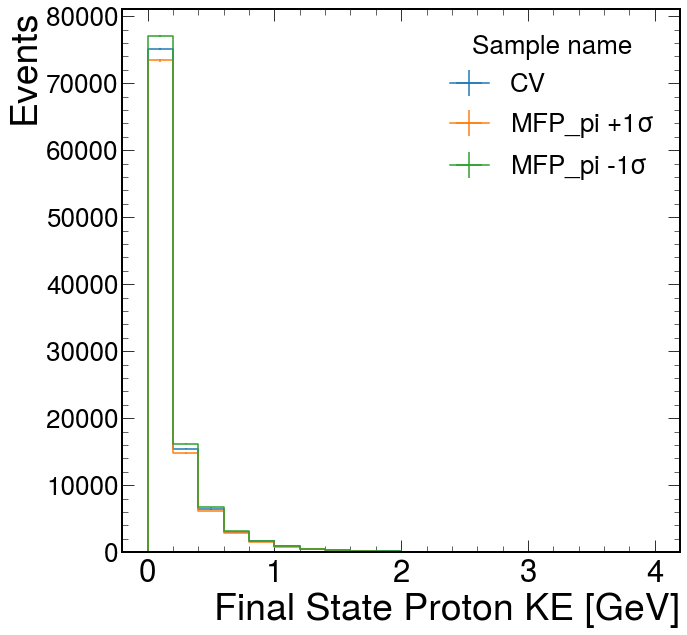

In [10]:
hist.plot1d(hists["p1_ke"], overflow = 'all')
print(save_path + "final_state_p1_ke_loose_trigger.pdf")
plt.savefig(save_path + "final_state_p1_ke_tight_trigger.pdf", bbox_inches = 'tight')

/u/gu/dhoang/ldmx_plot/01-04-2021final_state_l_pt_loose_trigger.pdf


'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


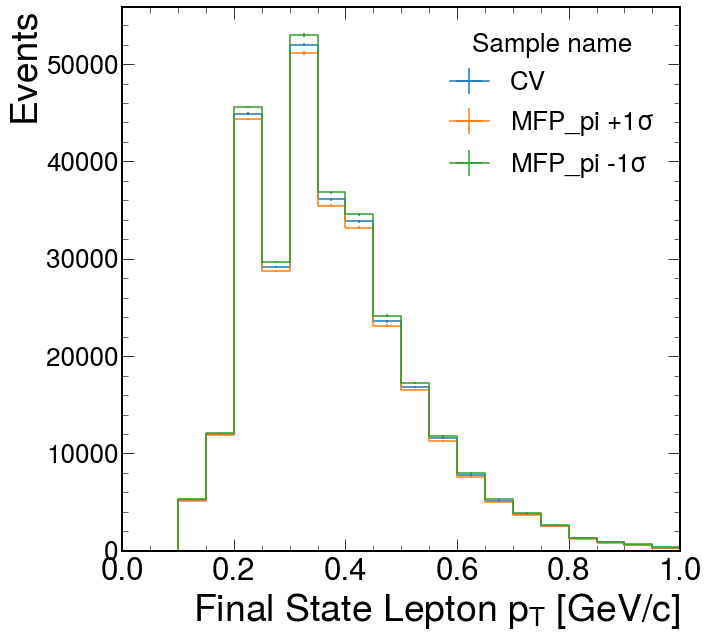

In [11]:
hist.plot1d(hists["lepton_pt"])
print(save_path + "final_state_l_pt_loose_trigger.pdf")
plt.savefig(save_path + "final_state_l_pt_tight_trigger.pdf", bbox_inches = 'tight')

/u/gu/dhoang/ldmx_plot/01-04-2021final_state_e_pt_loose_trigger.pdf


'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


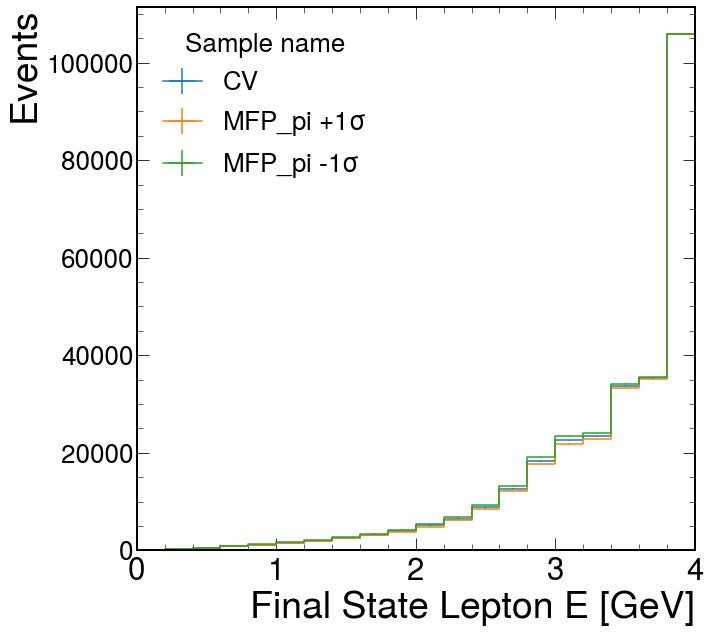

In [12]:
hist.plot1d(hists["lepton_e"])
print(save_path + "final_state_e_pt_loose_trigger.pdf")
plt.savefig(save_path + "final_state_e_pt_tight_trigger.pdf", bbox_inches = 'tight')